# Preprocessing for Time Series Modeling

This notebook prepares the 311 service request data for time series forecasting. Based on EDA observations:
- 1.6M records from 2019-2024
- Strong temporal patterns (hourly, daily, weekly)
- Multiple request types and neighborhoods
- ~0.8% missing coordinates, ~0.1% missing neighborhoods

We'll create daily/weekly aggregations by neighborhood and request type for time series modeling.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../data/raw/311_2019_2024.parquet')
print(f"Loaded {len(df):,} records")
print(f"Date range: {df['open_dt'].min()} to {df['open_dt'].max()}")

Loaded 1,609,901 records
Date range: 2019-01-01 00:03:00 to 2024-12-31 23:55:16


## Step 1: Data Type Conversions

In [2]:
df['open_dt'] = pd.to_datetime(df['open_dt'])
df['date'] = df['open_dt'].dt.date
df['year'] = df['open_dt'].dt.year
df['month'] = df['open_dt'].dt.month
df['day'] = df['open_dt'].dt.day
df['dayofweek'] = df['open_dt'].dt.dayofweek 
df['hour'] = df['open_dt'].dt.hour
df['week'] = df['open_dt'].dt.isocalendar().week

df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

print("Data types converted successfully")
df.dtypes

Data types converted successfully


open_dt         datetime64[ns]
case_title              object
subject                 object
reason                  object
type                    object
neighborhood            object
latitude               float64
longitude              float64
year                     int32
date                    object
month                    int32
day                      int32
dayofweek                int32
hour                     int32
week                    UInt32
dtype: object

## Step 2: Handle Missing Values

In [3]:
print("Missing values before cleaning:")
print(df[['neighborhood', 'type', 'subject', 'latitude', 'longitude']].isnull().sum())
print(f"\nTotal records: {len(df):,}")

df['neighborhood'] = df['neighborhood'].fillna('Unknown')

print("\nRecords after handling missing values:", len(df))

Missing values before cleaning:
neighborhood     1448
type                0
subject             0
latitude        12287
longitude       12287
dtype: int64

Total records: 1,609,901

Records after handling missing values: 1609901


## Step 3: Clean and Standardize Categories

In [4]:
print("Top 15 request types:")
print(df['type'].value_counts().head(15))

type_counts = df['type'].value_counts()
min_requests = 1000 
rare_types = type_counts[type_counts < min_requests].index
df['type_clean'] = df['type'].apply(lambda x: 'Other' if x in rare_types else x)

print("\nRequest types before:" , df['type'].nunique())
print("Request types after grouping:", df['type_clean'].nunique())

Top 15 request types:
type
Parking Enforcement                            315298
Requests for Street Cleaning                   118433
Improper Storage of Trash (Barrels)             95367
CE Collection                                   77653
Missed Trash/Recycling/Yard Waste/Bulk Item     75501
Request for Pothole Repair                      70873
Needle Pickup                                   55040
Schedule a Bulk Item Pickup                     46485
Poor Conditions of Property                     41894
Tree Maintenance Requests                       39957
Pick up Dead Animal                             36553
Street Light Outages                            35911
Sign Repair                                     33710
Request for Recycling Cart                      32233
Sidewalk Repair (Make Safe)                     31597
Name: count, dtype: int64

Request types before: 188
Request types after grouping: 87


In [5]:
print("Top 20 neighborhoods:")
print(df['neighborhood'].value_counts().head(20))

neighborhood_counts = df['neighborhood'].value_counts()
min_neighborhood_requests = 500
rare_neighborhoods = neighborhood_counts[neighborhood_counts < min_neighborhood_requests].index
df['neighborhood_clean'] = df['neighborhood'].apply(
    lambda x: 'Other_Neighborhood' if x in rare_neighborhoods else x
)

print("\nNeighborhoods before:", df['neighborhood'].nunique())
print("Neighborhoods after grouping:", df['neighborhood_clean'].nunique())

Top 20 neighborhoods:
neighborhood
Dorchester                                      227247
Roxbury                                         142341
South Boston / South Boston Waterfront          134253
Allston / Brighton                              115919
South End                                       108938
East Boston                                     108558
Jamaica Plain                                    92683
Downtown / Financial District                    90021
Back Bay                                         79067
Hyde Park                                        64683
Greater Mattapan                                 63773
Boston                                           57723
Roslindale                                       56057
Charlestown                                      55307
West Roxbury                                     52630
Beacon Hill                                      48225
Fenway / Kenmore / Audubon Circle / Longwood     31214
Mission Hill                  

## Step 4: Create Time Series Aggregations

We'll create multiple aggregation levels for different modeling approaches:

### 4.1 Daily Total Requests (Citywide)

In [6]:
daily_total = df.groupby('date').size().reset_index(name='count')
daily_total['date'] = pd.to_datetime(daily_total['date'])
daily_total = daily_total.sort_values('date')

date_range = pd.date_range(start=daily_total['date'].min(), 
                            end=daily_total['date'].max(), 
                            freq='D')
daily_total = daily_total.set_index('date').reindex(date_range, fill_value=0).reset_index()
daily_total.columns = ['date', 'count']

print("Daily total time series:", len(daily_total), "days")
print("Date range:", daily_total['date'].min(), "to", daily_total['date'].max())
print("\nSample:")
print(daily_total.head(10))

Daily total time series: 2192 days
Date range: 2019-01-01 00:00:00 to 2024-12-31 00:00:00

Sample:
        date  count
0 2019-01-01    381
1 2019-01-02    689
2 2019-01-03    636
3 2019-01-04    763
4 2019-01-05    341
5 2019-01-06    300
6 2019-01-07    788
7 2019-01-08    646
8 2019-01-09    722
9 2019-01-10    609


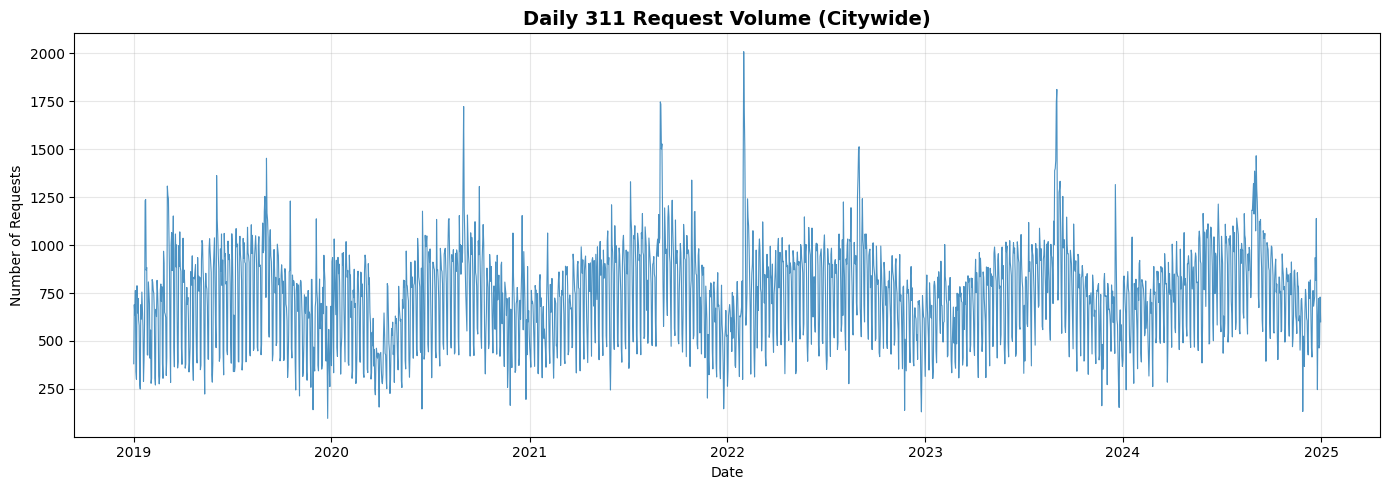

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(daily_total['date'], daily_total['count'], linewidth=0.8, alpha=0.8)
plt.title('Daily 311 Request Volume (Citywide)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Daily Requests by Request Type

In [8]:
daily_by_type = df.groupby(['date', 'type_clean']).size().reset_index(name='count')
daily_by_type['date'] = pd.to_datetime(daily_by_type['date'])

daily_type_wide = daily_by_type.pivot(index='date', columns='type_clean', values='count')
daily_type_wide = daily_type_wide.fillna(0).astype(int)


date_range = pd.date_range(start=daily_type_wide.index.min(), 
                            end=daily_type_wide.index.max(), 
                            freq='D')
daily_type_wide = daily_type_wide.reindex(date_range, fill_value=0)
daily_type_wide.index.name = 'date'

print("Daily by type shape:", daily_type_wide.shape)
print("Request types:", daily_type_wide.columns.tolist())
print("\nSample:")
print(daily_type_wide.head())

Daily by type shape: (2192, 87)
Request types: ['Abandoned Bicycle', 'Abandoned Vehicles', 'Animal Found', 'Animal Generic Request', 'Animal Lost', 'BWSC General Request', 'Building Inspection Request', 'CE Collection', 'Catchbasin', 'Chronic Dampness/Mold', 'Construction Debris', 'Contractor Complaints', 'Contractors Complaint', 'Electrical', 'Empty Litter Basket', 'Equipment Repair', 'Exceeding Terms of Permit', 'Fire Hydrant', 'General Comments For An Employee', 'General Comments For a Program or Policy', 'General Lighting Request', 'Graffiti Removal', 'Ground Maintenance', 'Heat - Excessive  Insufficient', 'Illegal Auto Body Shop', 'Illegal Dumping', 'Improper Storage of Trash (Barrels)', 'Knockdown Replacement', 'Loud Parties/Music/People', 'Maintenance - Homeowner', 'Maintenance Complaint - Residential', 'Major System Failure', 'Mice Infestation - Residential', 'Misc. Snow Complaint', 'Missed Trash/Recycling/Yard Waste/Bulk Item', 'Missing Sign', 'Needle Pickup', 'New Sign  Cross

### 4.3 Daily Requests by Neighborhood

In [9]:
daily_by_neighborhood = df.groupby(['date', 'neighborhood_clean']).size().reset_index(name='count')
daily_by_neighborhood['date'] = pd.to_datetime(daily_by_neighborhood['date'])

daily_neighborhood_wide = daily_by_neighborhood.pivot(
    index='date', columns='neighborhood_clean', values='count'
)
daily_neighborhood_wide = daily_neighborhood_wide.fillna(0).astype(int)

date_range = pd.date_range(start=daily_neighborhood_wide.index.min(), 
                            end=daily_neighborhood_wide.index.max(), 
                            freq='D')
daily_neighborhood_wide = daily_neighborhood_wide.reindex(date_range, fill_value=0)
daily_neighborhood_wide.index.name = 'date'

print("Daily by neighborhood shape:", daily_neighborhood_wide.shape)
print("Neighborhoods:", len(daily_neighborhood_wide.columns))
print("\nTop 10 neighborhoods by total volume:")
print(daily_neighborhood_wide.sum().sort_values(ascending=False).head(10))

Daily by neighborhood shape: (2192, 25)
Neighborhoods: 25

Top 10 neighborhoods by total volume:
neighborhood_clean
Dorchester                                227247
Roxbury                                   142341
South Boston / South Boston Waterfront    134253
Allston / Brighton                        115919
South End                                 108938
East Boston                               108558
Jamaica Plain                              92683
Downtown / Financial District              90021
Back Bay                                   79067
Hyde Park                                  64683
dtype: int64


### 4.4 Weekly Aggregations (for longer-term forecasting)

In [10]:
df['week_start'] = df['open_dt'] - pd.to_timedelta(df['open_dt'].dt.dayofweek, unit='d')
df['week_start'] = df['week_start'].dt.date

weekly_total = df.groupby('week_start').size().reset_index(name='count')
weekly_total['week_start'] = pd.to_datetime(weekly_total['week_start'])
weekly_total = weekly_total.sort_values('week_start')

print("Weekly total time series:", len(weekly_total))
print("\nSample:")
print(weekly_total.head(10))

Weekly total time series: 314

Sample:
  week_start  count
0 2018-12-31   3110
1 2019-01-07   3871
2 2019-01-14   3983
3 2019-01-21   5676
4 2019-01-28   3799
5 2019-02-04   4365
6 2019-02-11   4121
7 2019-02-18   4056
8 2019-02-25   4518
9 2019-03-04   6474


In [11]:
weekly_by_type = df.groupby(['week_start', 'type_clean']).size().reset_index(name='count')
weekly_by_type['week_start'] = pd.to_datetime(weekly_by_type['week_start'])

weekly_type_wide = weekly_by_type.pivot(index='week_start', columns='type_clean', values='count')
weekly_type_wide = weekly_type_wide.fillna(0).astype(int)
weekly_type_wide.index.name = 'week_start'

print("Weekly by type shape:", weekly_type_wide.shape)
print(weekly_type_wide.head())

Weekly by type shape: (314, 87)
type_clean  Abandoned Bicycle  Abandoned Vehicles  Animal Found  \
week_start                                                        
2018-12-31                 15                  82             3   
2019-01-07                 18                  91             8   
2019-01-14                 33                 111             7   
2019-01-21                 27                 108             6   
2019-01-28                 22                 123             5   

type_clean  Animal Generic Request  Animal Lost  BWSC General Request  \
week_start                                                              
2018-12-31                      28            3                     2   
2019-01-07                      35            4                     4   
2019-01-14                      33            6                     6   
2019-01-21                      28            6                     6   
2019-01-28                      34            2             

### 4.5 Combined Dataset with Features for ML Models

In [12]:
daily_features = daily_total.copy()
daily_features['dayofweek'] = daily_features['date'].dt.dayofweek
daily_features['month'] = daily_features['date'].dt.month
daily_features['year'] = daily_features['date'].dt.year
daily_features['day_of_year'] = daily_features['date'].dt.dayofyear
daily_features['quarter'] = daily_features['date'].dt.quarter
daily_features['is_weekend'] = daily_features['dayofweek'].isin([5, 6]).astype(int)

for lag in [1, 7, 14, 30]:
    daily_features[f'count_lag_{lag}'] = daily_features['count'].shift(lag)

for window in [7, 14, 30]:
    daily_features[f'count_rolling_mean_{window}'] = daily_features['count'].rolling(
        window=window, min_periods=1
    ).mean()

daily_features['days_since_start'] = (
    daily_features['date'] - daily_features['date'].min()
).dt.days

print("Daily features shape:", daily_features.shape)
print("Columns:", daily_features.columns.tolist())
print("\nSample with features:")
print(daily_features.tail(10))

Daily features shape: (2192, 16)
Columns: ['date', 'count', 'dayofweek', 'month', 'year', 'day_of_year', 'quarter', 'is_weekend', 'count_lag_1', 'count_lag_7', 'count_lag_14', 'count_lag_30', 'count_rolling_mean_7', 'count_rolling_mean_14', 'count_rolling_mean_30', 'days_since_start']

Sample with features:
           date  count  dayofweek  month  year  day_of_year  quarter  \
2182 2024-12-22    817          6     12  2024          357        4   
2183 2024-12-23   1139          0     12  2024          358        4   
2184 2024-12-24    628          1     12  2024          359        4   
2185 2024-12-25    246          2     12  2024          360        4   
2186 2024-12-26    625          3     12  2024          361        4   
2187 2024-12-27    722          4     12  2024          362        4   
2188 2024-12-28    463          5     12  2024          363        4   
2189 2024-12-29    481          6     12  2024          364        4   
2190 2024-12-30    729          0     12  2

## Step 5: Export Processed Data

In [ ]:
daily_total.to_parquet('../data/processed/daily_total.parquet', index=False)

daily_type_wide.reset_index().to_parquet('../data/processed/daily_by_type.parquet', index=False)

daily_neighborhood_wide.reset_index().to_parquet('../data/processed/daily_by_neighborhood.parquet', index=False)

weekly_total.to_parquet('../data/processed/weekly_total.parquet', index=False)

weekly_type_wide.reset_index().to_parquet('../data/processed/weekly_by_type.parquet', index=False)

daily_features.to_parquet('../data/processed/daily_features.parquet', index=False)

df_clean = df[['open_dt', 'date', 'type_clean', 'neighborhood_clean', 
               'subject', 'reason', 'latitude', 'longitude', 
               'year', 'month', 'dayofweek', 'hour']].copy()
df_clean.to_parquet('../data/processed/311_cleaned.parquet', index=False)

print("\n" + "="*60)
print("All datasets exported successfully!")
print("="*60)


All datasets exported successfully!
